In [1]:
import rosbag2_py
from rclpy.serialization import deserialize_message
import importlib
import rclpy.logging

# To suppress logging output
rclpy.logging.set_logger_level("rosbag2_storage", rclpy.logging.LoggingSeverity.FATAL)


In [2]:
def get_rosbag_options(path: str):
    storage_options = rosbag2_py.StorageOptions(uri=path, storage_id="sqlite3")
    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format="cdr", output_serialization_format="cdr"
    )
    return storage_options, converter_options


def load_bag(path: str):
    reader = rosbag2_py.SequentialReader()
    reader.open(*get_rosbag_options(path))
    return reader


def get_type_from_str(type_str: str):
    # dynamic load message package
    pkg = importlib.import_module(".".join(type_str.split("/")[:-1]))
    return eval(f"pkg.{type_str.split('/')[-1]}")


In [3]:
bag = load_bag("data/mix.bag")


In [4]:
type_table = {}
for meta in bag.get_all_topics_and_types():
    type_table[meta.name] = get_type_from_str(meta.type)
print(type_table)


{'/image': <class 'sensor_msgs.msg._image.Image'>, '/point': <class 'geometry_msgs.msg._point.Point'>, '/chatter': <class 'std_msgs.msg._string.String'>, '/number': <class 'std_msgs.msg._int32.Int32'>}


In [5]:
bag.seek(0)
for _ in range(10):
    message = bag.read_next()
    print(
        message[0],  # topic name
        # message[1], # topic data (cdr)
        message[2],  # timestamp
    )


/number 0
/chatter 1000000
/point 2000000
/image 3000000
/point 100000000
/image 101000000
/point 200000000
/image 201000000
/point 300000000
/image 301000000


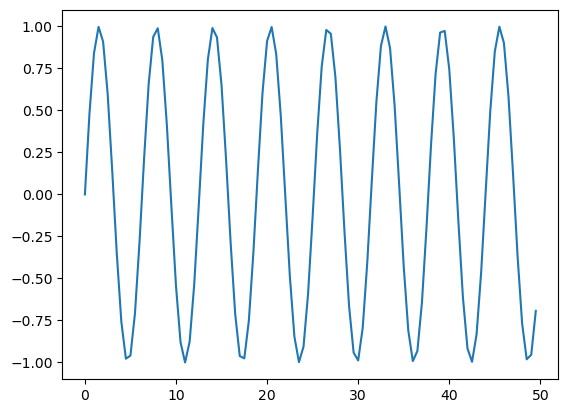

In [6]:
import matplotlib.pyplot as plt

filter = rosbag2_py.StorageFilter(topics=["/point"])

bag.seek(0)
bag.set_filter(filter)

pts = []

while bag.has_next():
    message = bag.read_next()
    pts.append(deserialize_message(message[1], type_table[message[0]]))

plt.plot([p.x for p in pts], [p.y for p in pts])


bgr8


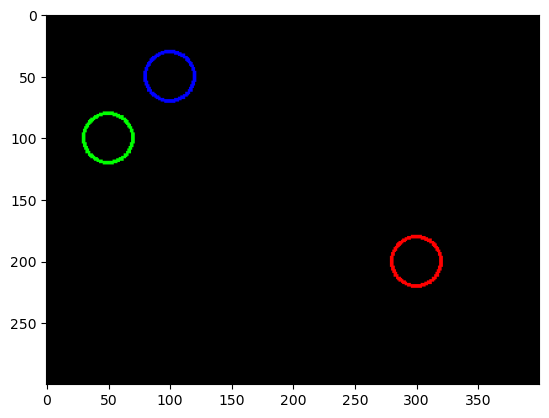

In [8]:
import cv2
import cv_bridge

bridge = cv_bridge.CvBridge()

filter = rosbag2_py.StorageFilter(topics=["/image"])

bag.seek(0)
bag.set_filter(filter)

message = bag.read_next()

image_ros = deserialize_message(message[1], type_table[message[0]])

print(image_ros.encoding)
image = bridge.imgmsg_to_cv2(image_ros)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
